In [1]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.visualization import TextVisualization
from mesa.batchrunner import BatchRunner
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import schelling # custom module

## Simulation with separated cut-offs 

- check whether the productivity rules are set right 
    * minotiry group (= high-productive employees) gains productivity when they are surrounded with at least 1 other high-productive employee. 
    * majority group (= low-productive employees) gains producitivity when they are surrounded with at least 2 high-productive employee. 
    

In [458]:
class SchellingAgent(Agent):
    def __init__(self, pos, model, agent_type):
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type       
        
    def step(self):
        # Each agent will loop over neighbors (built-in iterator on grids),
        # and determine how many of them are high-productiveworkers 
        
        ex_worker = 0 #check how many neighbors are high-productive workers
        for neighbor in self.model.grid.neighbor_iter(self.pos):
            if neighbor.type == 1:
                ex_worker += 1
        
        if self.type == 1: #minority 
            if ex_worker < self.model.minor_bar:
                productivity = "I'm unproductive!"
            else:
                productivity = "I'm productive!"
                self.model.productivity += 1
        else:
            if ex_worker < self.model.major_bar:
                productivity = "I'm unproductive!"
            else:
                productivity = "I'm productive!"
                self.model.productivity += 1
                self.type = 2
    
        print("Hello, I'm an agent of type {} with ex_worker {} around and {}".format(self.type,
                                                                            ex_worker,
                                                                            productivity)) 
         
            

class SchellingModel(Model):
    def __init__(self, height=6, width=6,
                 density=0.8, minority_pc=0.25, major_bar=2, minor_bar =1):
        self.height = height #define grid 
        self.width = width #define grid 
        self.density = density #% of agents in the grid 
        self.minority_pc = minority_pc #% of minority group
        self.major_bar = major_bar
        self.minor_bar = minor_bar
        
        # Create grid, that can contain at most one thing in each cell
        self.grid = SingleGrid(width, height, torus=True)
        
        # Establish scheduler
        self.schedule = RandomActivation(self)
        
        self.productivity = 0 
        
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            
            if self.random.random() < self.density:
                if self.random.random() < self.minority_pc:
                    agent_type = 1 #set minority 
                else:
                    agent_type = 0
                    
                agent = SchellingAgent((x, y), self, agent_type)
            
                # Add agent to the schedule
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)
            
    
    def step(self):
       
        #self.productivity = 0

        # shuffles order of the agents, then activates + executes
        # each agent's step method
        self.schedule.step()
            
model = SchellingModel()
model.step()

print(model.productivity)

Hello, I'm an agent of type 2 with ex_worker 2 around and I'm productive!
Hello, I'm an agent of type 1 with ex_worker 3 around and I'm productive!
Hello, I'm an agent of type 1 with ex_worker 2 around and I'm productive!
Hello, I'm an agent of type 0 with ex_worker 1 around and I'm unproductive!
Hello, I'm an agent of type 1 with ex_worker 1 around and I'm productive!
Hello, I'm an agent of type 0 with ex_worker 1 around and I'm unproductive!
Hello, I'm an agent of type 2 with ex_worker 2 around and I'm productive!
Hello, I'm an agent of type 2 with ex_worker 3 around and I'm productive!
Hello, I'm an agent of type 0 with ex_worker 1 around and I'm unproductive!
Hello, I'm an agent of type 0 with ex_worker 1 around and I'm unproductive!
Hello, I'm an agent of type 0 with ex_worker 1 around and I'm unproductive!
Hello, I'm an agent of type 1 with ex_worker 1 around and I'm productive!
Hello, I'm an agent of type 2 with ex_worker 2 around and I'm productive!
Hello, I'm an agent of type 

## Test Case 1: high-productive employees move to empty cells no matter whether they gain productivity at the moment 

* the low-productive employees only move when they fail to gain productivity at the moment 
* the low-productive employees will be labeled as type 2 if they are surrounded by at least 2 high-productive employees

In [461]:
class SchellingAgent(Agent):
    def __init__(self, pos, model, agent_type):
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type
        
        
        
    def step(self):
        
        ex_worker = 0 
        for neighbor in self.model.grid.neighbor_iter(self.pos):
            if neighbor.type == 1:
                ex_worker += 1
        
        if self.type == 1: #minority 
            self.model.type_1 += 1 
            if ex_worker < self.model.minor_bar:
                self.model.grid.move_to_empty(self)
            else:
                self.model.productivity += 1
                self.model.grid.move_to_empty(self)
        else:
            if ex_worker < self.model.major_bar:
                self.model.grid.move_to_empty(self)
                self.model.type_0 +=1
            else:
                self.model.productivity += 1
                self.type = 2
                self.model.type_2 +=1 
        

class SchellingModel(Model):
    def __init__(self, height=10, width=10,
                 density=0.80, minority_pc=0.25, major_bar=2, minor_bar =1):
        self.height = height #define grid 
        self.width = width #define grid 
        self.density = density #% of agents in the grid 
        self.minority_pc = minority_pc #% of minority group
        self.major_bar = major_bar
        self.minor_bar = minor_bar
        
        # Create grid, that can contain at most one thing in each cell
        self.grid = SingleGrid(width, height, torus=True)
        
        # Establish scheduler
        self.schedule = RandomActivation(self)
        
        self.productivity = 0  
        self.type_0 = 0
        self.type_1 = 0
        self.type_2 = 0  
        self.count = 0 
        self.differ = 0 
        
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            
            if self.random.random() < self.density:
                if self.random.random() < self.minority_pc:
                    agent_type = 1 #set minority 
                else:
                    agent_type = 0
                    
                agent = SchellingAgent((x, y), self, agent_type)
            
                # Add agent to the schedule
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)
            
    
    def step(self):
        
        self.productivity = 0 
        self.type_0 = 0
        self.type_1 = 0
        self.type_2 = 0 
        self.schedule.step()
        self.type_0 = round(self.type_0 /self.schedule.get_agent_count()*100,2)
        self.type_1 = round(self.type_1 /self.schedule.get_agent_count()*100,2)
        self.type_2 = round(self.type_2 /self.schedule.get_agent_count()*100,2)
        self.differ = self.productivity - self.count
        self.count = self.productivity

In [329]:
model = SchellingModel()
for i in range(10):
    model.step()
    print("productivity:", model.productivity,
          "increase in productivity:",model.differ,
          "type 0:", model.type_0,"%",
          "type 1:", model.type_1,"%",
          "type 2:", model.type_2,"%",)

productivity: 44 increase in productivity: 44 type 0: 38.46 % type 1: 24.36 % type 2: 37.18 %
productivity: 47 increase in productivity: 3 type 0: 34.62 % type 1: 24.36 % type 2: 41.03 %
productivity: 54 increase in productivity: 7 type 0: 26.92 % type 1: 24.36 % type 2: 48.72 %
productivity: 45 increase in productivity: -9 type 0: 35.9 % type 1: 24.36 % type 2: 39.74 %
productivity: 48 increase in productivity: 3 type 0: 35.9 % type 1: 24.36 % type 2: 39.74 %
productivity: 43 increase in productivity: -5 type 0: 35.9 % type 1: 24.36 % type 2: 39.74 %
productivity: 52 increase in productivity: 9 type 0: 28.21 % type 1: 24.36 % type 2: 47.44 %
productivity: 46 increase in productivity: -6 type 0: 33.33 % type 1: 24.36 % type 2: 42.31 %
productivity: 45 increase in productivity: -1 type 0: 37.18 % type 1: 24.36 % type 2: 38.46 %
productivity: 36 increase in productivity: -9 type 0: 43.59 % type 1: 24.36 % type 2: 32.05 %


# visualizations

In [439]:
model = SchellingModel()
p1 = []
i1 = []
t1 = []
for i in range(10):
    model.step()
    p1.append(model.productivity)
    i1.append(model.differ)
    t1.append(model.type_2)

In [440]:
model = SchellingModel()
p2 = []
i2 = []
t2 = []
for i in range(10):
    model.step()
    p2.append(model.productivity)
    i2.append(model.differ)
    t2.append(model.type_2)

In [441]:
model = SchellingModel()
p3 = []
i3 = []
t3 = []
for i in range(10):
    model.step()
    p3.append(model.productivity)
    i3.append(model.differ)
    t3.append(model.type_2)

In [442]:
model = SchellingModel()
p4 = []
i4 = []
t4 = []
for i in range(10):
    model.step()
    p4.append(model.productivity)
    i4.append(model.differ)
    t4.append(model.type_2)

In [443]:
model = SchellingModel()
p5 = []
i5 = []
t5 = []
for i in range(10):
    model.step()
    p5.append(model.productivity)
    i5.append(model.differ)
    t5.append(model.type_2)

In [539]:
x = np.arange(1,11)
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

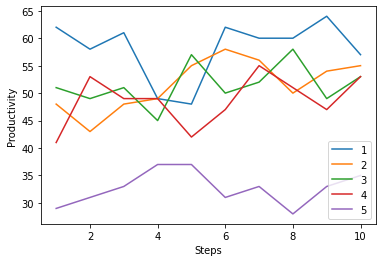

In [444]:
plt.plot(x,p1,label = "1")
plt.plot(x,p2,label = "2")
plt.plot(x,p3,label = "3")
plt.plot(x,p4,label = "4")
plt.plot(x,p5,label = "5")
plt.xlabel("Steps")
plt.ylabel("Productivity")
plt.legend()
plt.show();

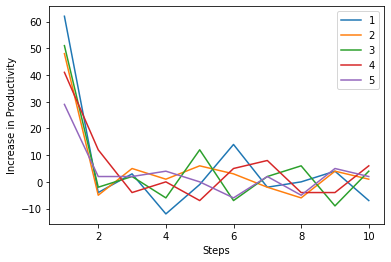

In [445]:
plt.plot(x,i1,label = "1")
plt.plot(x,i2,label = "2")
plt.plot(x,i3,label = "3")
plt.plot(x,i4,label = "4")
plt.plot(x,i5,label = "5")
plt.xlabel("Steps")
plt.ylabel("Increase in Productivity")
plt.legend()
plt.show();

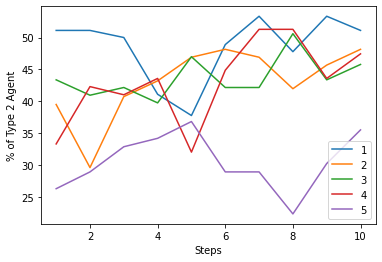

In [446]:
plt.plot(x,t1,label = "1")
plt.plot(x,t2,label = "2")
plt.plot(x,t3,label = "3")
plt.plot(x,t4,label = "4")
plt.plot(x,t5,label = "5")
plt.xlabel("Steps")
plt.ylabel("% of Type 2 Agent")
plt.legend()
plt.show();

## Test Case 2: high-productive employees only move to empty cells when they fail to gain productivity at the moment 

* the low-productive employees only move when they fail to gain productivity at the moment 
* the low-productive employees will be labeled as type 2 if they are surrounded by at least 2 high-productive employees

In [580]:
class SchellingAgent(Agent):
    def __init__(self, pos, model, agent_type):
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type
        
        
    def step(self):
     
        ex_worker = 0 
        for neighbor in self.model.grid.neighbor_iter(self.pos):
            if neighbor.type == 1:
                ex_worker += 1
        
        if self.type == 1: #minority 
            self.model.type_1 += 1 
            if ex_worker < self.model.minor_bar:
                self.model.grid.move_to_empty(self)
            else:
                self.model.productivity += 1
              
        else:
            if ex_worker < self.model.major_bar:
                self.model.grid.move_to_empty(self)
                self.model.type_0 +=1
            else:
                self.model.productivity += 1
                self.type = 2
                self.model.type_2 +=1 
            
                

class SchellingModel(Model):
    def __init__(self, height=10, width=10,
                 density=0.80, minority_pc=0.25, major_bar=2, minor_bar =1):
        self.height = height #define grid 
        self.width = width #define grid 
        self.density = density #% of agents in the grid 
        self.minority_pc = minority_pc #% of minority group
        self.major_bar = major_bar
        self.minor_bar = minor_bar
        
        # Create grid, that can contain at most one thing in each cell
        self.grid = SingleGrid(width, height, torus=True)
        
        # Establish scheduler
        self.schedule = RandomActivation(self)
        
        self.productivity = 0  
        self.type_0 = 0
        self.type_1 = 0
        self.type_2 = 0  
        self.count = 0 
        self.differ = 0 
        
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            
            if self.random.random() < self.density:
                if self.random.random() < self.minority_pc:
                    agent_type = 1 #set minority 
                else:
                    agent_type = 0
                    
                agent = SchellingAgent((x, y), self, agent_type)
            
                # Add agent to the schedule
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)
            
    
    def step(self):
        
        self.productivity = 0 
        self.type_0 = 0
        self.type_1 = 0
        self.type_2 = 0 
        self.schedule.step()
        self.type_0 = round(self.type_0 /self.schedule.get_agent_count()*100,2)
        self.type_1 = round(self.type_1 /self.schedule.get_agent_count()*100,2)
        self.type_2 = round(self.type_2 /self.schedule.get_agent_count()*100,2)
        self.differ = self.productivity - self.count
        self.count = self.productivity

In [448]:
model = SchellingModel()
for i in range(10):
    model.step()
    print("productivity:", model.productivity,
          "increase in productivity:",model.differ,
          "type 0:", model.type_0,"%",
          "type 1:", model.type_1,"%",
          "type 2:", model.type_2,"%",)

productivity: 45 increase in productivity: 45 type 0: 40.24 % type 1: 23.17 % type 2: 36.59 %
productivity: 56 increase in productivity: 11 type 0: 30.49 % type 1: 23.17 % type 2: 46.34 %
productivity: 56 increase in productivity: 0 type 0: 30.49 % type 1: 23.17 % type 2: 46.34 %
productivity: 55 increase in productivity: -1 type 0: 31.71 % type 1: 23.17 % type 2: 45.12 %
productivity: 55 increase in productivity: 0 type 0: 31.71 % type 1: 23.17 % type 2: 45.12 %
productivity: 58 increase in productivity: 3 type 0: 29.27 % type 1: 23.17 % type 2: 47.56 %
productivity: 58 increase in productivity: 0 type 0: 29.27 % type 1: 23.17 % type 2: 47.56 %
productivity: 58 increase in productivity: 0 type 0: 29.27 % type 1: 23.17 % type 2: 47.56 %
productivity: 58 increase in productivity: 0 type 0: 29.27 % type 1: 23.17 % type 2: 47.56 %
productivity: 58 increase in productivity: 0 type 0: 29.27 % type 1: 23.17 % type 2: 47.56 %


# visualizations

In [449]:
model2 = SchellingModel()
p1 = []
i1 = []
t1 = []
for i in range(10):
    model2.step()
    p1.append(model2.productivity)
    i1.append(model2.differ)
    t1.append(model2.type_2)

In [450]:
model2 = SchellingModel()
p2 = []
i2 = []
t2 = []
for i in range(10):
    model2.step()
    p2.append(model2.productivity)
    i2.append(model2.differ)
    t2.append(model2.type_2)

In [451]:
model2 = SchellingModel()
p3 = []
i3 = []
t3 = []
for i in range(10):
    model2.step()
    p3.append(model2.productivity)
    i3.append(model2.differ)
    t3.append(model2.type_2)

In [452]:
model2 = SchellingModel()
p4 = []
i4 = []
t4 = []
for i in range(10):
    model2.step()
    p4.append(model2.productivity)
    i4.append(model2.differ)
    t4.append(model2.type_2)

In [453]:
model2 = SchellingModel()
p5 = []
i5 = []
t5 = []
for i in range(10):
    model2.step()
    p5.append(model2.productivity)
    i5.append(model2.differ)
    t5.append(model2.type_2)

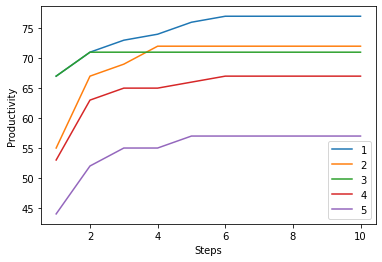

In [454]:
plt.plot(x,p1,label = "1")
plt.plot(x,p2,label = "2")
plt.plot(x,p3,label = "3")
plt.plot(x,p4,label = "4")
plt.plot(x,p5,label = "5")
plt.xlabel("Steps")
plt.ylabel("Productivity")
plt.legend()
plt.show();

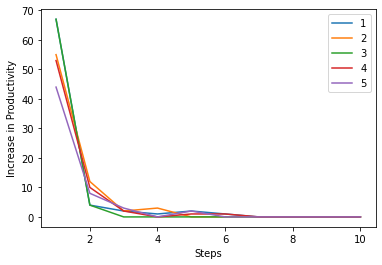

In [455]:
plt.plot(x,i1,label = "1")
plt.plot(x,i2,label = "2")
plt.plot(x,i3,label = "3")
plt.plot(x,i4,label = "4")
plt.plot(x,i5,label = "5")
plt.xlabel("Steps")
plt.ylabel("Increase in Productivity")
plt.legend()
plt.show();

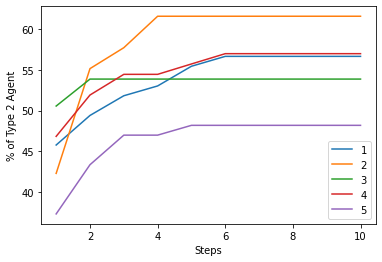

In [456]:
plt.plot(x,t1,label = "1")
plt.plot(x,t2,label = "2")
plt.plot(x,t3,label = "3")
plt.plot(x,t4,label = "4")
plt.plot(x,t5,label = "5")
plt.xlabel("Steps")
plt.ylabel("% of Type 2 Agent")
plt.legend()
plt.show();

## Test for different minority percentage values

In [611]:
# 0.1
step_1_0 =[]
step_2_0 =[]
step_3_0 =[]
step_4_0 =[]
step_5_0 =[]
step_11_0 =[]
step_22_0 =[]
step_33_0 =[]
step_44_0 =[]
step_55_0 =[]

for i in range(100):
    
    model = SchellingModel(minority_pc = 0.1)

    model.step()
    step_1_0.append(model.productivity)
    step_11_0.append(model.type_2)
    model.step()
    step_2_0.append(model.productivity)
    step_22_0.append(model.type_2)
    model.step()
    step_3_0.append(model.productivity)
    step_33_0.append(model.type_2)
    model.step()
    step_4_0.append(model.productivity)
    step_44_0.append(model.type_2)
    model.step()
    step_5_0.append(model.productivity)
    step_55_0.append(model.type_2)

In [612]:
# 0.2
step_1_1 =[]
step_2_1 =[]
step_3_1 =[]
step_4_1 =[]
step_5_1 =[]
step_11_1 =[]
step_22_1 =[]
step_33_1 =[]
step_44_1 =[]
step_55_1 =[]

for i in range(100):
    
    model = SchellingModel(minority_pc = 0.2)

    model.step()
    step_1_1.append(model.productivity)
    step_11_1.append(model.type_2)
    model.step()
    step_2_1.append(model.productivity)
    step_22_1.append(model.type_2)
    model.step()
    step_3_1.append(model.productivity)
    step_33_1.append(model.type_2)
    model.step()
    step_4_1.append(model.productivity)
    step_44_1.append(model.type_2)
    model.step()
    step_5_1.append(model.productivity)
    step_55_1.append(model.type_2)

In [613]:
# 0.3
step_1_2 =[]
step_2_2 =[]
step_3_2 =[]
step_4_2 =[]
step_5_2 =[]
step_11_2 =[]
step_22_2 =[]
step_33_2 =[]
step_44_2 =[]
step_55_2 =[]

for i in range(100):
    
    model = SchellingModel(minority_pc = 0.3)

    model.step()
    step_1_2.append(model.productivity)
    step_11_2.append(model.type_2)
    model.step()
    step_2_2.append(model.productivity)
    step_22_2.append(model.type_2)
    model.step()
    step_3_2.append(model.productivity)
    step_33_2.append(model.type_2)
    model.step()
    step_4_2.append(model.productivity)
    step_44_2.append(model.type_2)
    model.step()
    step_5_2.append(model.productivity)
    step_55_2.append(model.type_2)

In [614]:
# 0.4
step_1_3 =[]
step_2_3 =[]
step_3_3 =[]
step_4_3 =[]
step_5_3 =[]
step_11_3 =[]
step_22_3 =[]
step_33_3 =[]
step_44_3 =[]
step_55_3 =[]

for i in range(100):
    
    model = SchellingModel(minority_pc = 0.4)

    model.step()
    step_1_3.append(model.productivity)
    step_11_3.append(model.type_2)
    model.step()
    step_2_3.append(model.productivity)
    step_22_3.append(model.type_2)
    model.step()
    step_3_3.append(model.productivity)
    step_33_3.append(model.type_2)
    model.step()
    step_4_3.append(model.productivity)
    step_44_3.append(model.type_2)
    model.step()
    step_5_3.append(model.productivity)
    step_55_3.append(model.type_2)

In [641]:
# 0.5
step_1_4 =[]
step_2_4 =[]
step_3_4 =[]
step_4_4 =[]
step_5_4 =[]
step_11_4 =[]
step_22_4 =[]
step_33_4 =[]
step_44_4 =[]
step_55_4 =[]

for i in range(100):
    
    model = SchellingModel(minority_pc = 0.5)

    model.step()
    step_1_4.append(model.productivity)
    step_11_4.append(model.type_2)
    model.step()
    step_2_4.append(model.productivity)
    step_22_4.append(model.type_2)
    model.step()
    step_3_4.append(model.productivity)
    step_33_4.append(model.type_2)
    model.step()
    step_4_4.append(model.productivity)
    step_44_4.append(model.type_2)
    model.step()
    step_5_4.append(model.productivity)
    step_55_4.append(model.type_2)

In [642]:
# 0.6
step_1_5 =[]
step_2_5 =[]
step_3_5 =[]
step_4_5 =[]
step_5_5 =[]
step_11_5 =[]
step_22_5 =[]
step_33_5 =[]
step_44_5 =[]
step_55_5 =[]

for i in range(100):
    
    model = SchellingModel(minority_pc = 0.6)

    model.step()
    step_1_5.append(model.productivity)
    step_11_5.append(model.type_2)
    model.step()
    step_2_5.append(model.productivity)
    step_22_5.append(model.type_2)
    model.step()
    step_3_5.append(model.productivity)
    step_33_5.append(model.type_2)
    model.step()
    step_4_5.append(model.productivity)
    step_44_5.append(model.type_2)
    model.step()
    step_5_5.append(model.productivity)
    step_55_5.append(model.type_2)

In [615]:
p_10 = [sum(step_1_0)/len(step_1_0), sum(step_2_0)/len(step_2_0),sum(step_3_0)/len(step_3_0),
        sum(step_4_0)/len(step_4_0),sum(step_5_0)/len(step_5_0)]
p_20 = [sum(step_1_1)/len(step_1_1), sum(step_2_1)/len(step_2_1),sum(step_3_1)/len(step_3_1),
        sum(step_4_1)/len(step_4_1),sum(step_5_1)/len(step_5_1)]
p_30 = [sum(step_1_2)/len(step_1_2), sum(step_2_2)/len(step_2_2),sum(step_3_2)/len(step_3_2),
        sum(step_4_2)/len(step_4_2),sum(step_5_2)/len(step_5_2)]
p_40 = [sum(step_1_3)/len(step_1_3), sum(step_2_3)/len(step_2_3),sum(step_3_3)/len(step_3_3),
        sum(step_4_3)/len(step_4_3),sum(step_5_3)/len(step_5_3)]

In [643]:
p_10 = [sum(step_1_0)/len(step_1_0), sum(step_2_0)/len(step_2_0),sum(step_3_0)/len(step_3_0),
        sum(step_4_0)/len(step_4_0),sum(step_5_0)/len(step_5_0)]
p_20 = [sum(step_1_1)/len(step_1_1), sum(step_2_1)/len(step_2_1),sum(step_3_1)/len(step_3_1),
        sum(step_4_1)/len(step_4_1),sum(step_5_1)/len(step_5_1)]
p_30 = [sum(step_1_2)/len(step_1_2), sum(step_2_2)/len(step_2_2),sum(step_3_2)/len(step_3_2),
        sum(step_4_2)/len(step_4_2),sum(step_5_2)/len(step_5_2)]
p_40 = [sum(step_1_3)/len(step_1_3), sum(step_2_3)/len(step_2_3),sum(step_3_3)/len(step_3_3),
        sum(step_4_3)/len(step_4_3),sum(step_5_3)/len(step_5_3)]
p_50 = [sum(step_1_4)/len(step_1_4), sum(step_2_4)/len(step_2_4),sum(step_3_4)/len(step_3_4),
        sum(step_4_4)/len(step_4_4),sum(step_5_4)/len(step_5_4)]
p_60 = [sum(step_1_5)/len(step_1_5), sum(step_2_5)/len(step_2_5),sum(step_3_5)/len(step_3_5),
        sum(step_4_5)/len(step_4_5),sum(step_5_5)/len(step_5_5)]

In [635]:
x = np.arange(1,6)

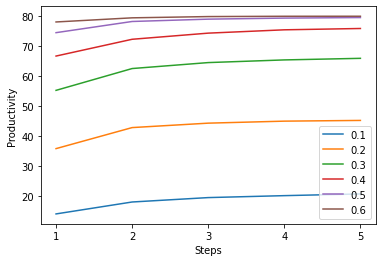

In [644]:
plt.plot(x,p_10,label = "0.1")
plt.plot(x,p_20,label = "0.2")
plt.plot(x,p_30,label = "0.3")
plt.plot(x,p_40,label = "0.4")
plt.plot(x,p_50,label = "0.5")
plt.plot(x,p_60,label = "0.6")
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("Steps")
plt.ylabel("Productivity")
plt.legend();

In [617]:
t_10 = [sum(step_11_0)/len(step_11_0), sum(step_22_0)/len(step_22_0),sum(step_33_0)/len(step_33_0),
        sum(step_44_0)/len(step_44_0),sum(step_55_0)/len(step_55_0)]
t_20 = [sum(step_11_1)/len(step_11_1), sum(step_22_1)/len(step_22_1),sum(step_33_1)/len(step_33_1),
        sum(step_44_1)/len(step_44_1),sum(step_55_1)/len(step_55_1)]
t_30 = [sum(step_11_2)/len(step_11_2), sum(step_22_2)/len(step_22_2),sum(step_33_2)/len(step_33_2),
        sum(step_44_2)/len(step_44_2),sum(step_55_2)/len(step_55_2)]
t_40 = [sum(step_11_3)/len(step_11_3), sum(step_22_3)/len(step_22_3),sum(step_33_3)/len(step_33_3),
        sum(step_44_3)/len(step_44_3),sum(step_55_3)/len(step_55_3)]

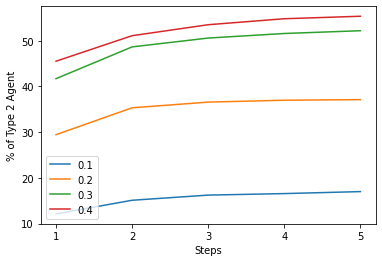

In [618]:
plt.plot(x,t_10,label = "0.1")
plt.plot(x,t_20,label = "0.2")
plt.plot(x,t_30,label = "0.3")
plt.plot(x,t_40,label = "0.4")
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("Steps")
plt.ylabel("% of Type 2 Agent")
plt.legend();

In [623]:
increase_type2 = [round((sum(step_55_0)/len(step_55_0)/90),2), round((sum(step_55_1)/len(step_55_1)/80),2),
                  round((sum(step_55_2)/len(step_55_2)/70),2), round((sum(step_55_3)/len(step_55_3)/60),2)] 

In [633]:
percent = [0.1,0.2,0.3,0.4]

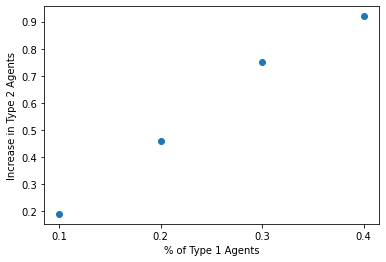

In [634]:
plt.scatter(percent,increase_type2)
plt.xticks([0.1,0.2,0.3,0.4])
plt.xlabel("% of Type 1 Agents")
plt.ylabel("Increase in Type 2 Agents");